# GRU Example

### Importing necessary libraries

In [1]:
import time
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter  # Import SummaryWriter

### Load and preprocess the data

In [2]:
data = pd.read_csv(
    '/Users/casper/Documents/GitHub/p9-energy/Examples/test-data/maj2023_2024.csv', sep=';')

# Convert 'Timestamp' column to datetime format
data['Timestamp'] = pd.to_datetime(
    data['Timestamp'], format='%d.%m.%Y %H.%M.%S')

# Separate the training and evaluation datasets
train_data = data[data['Timestamp'].dt.year == 2023]
eval_data = data[data['Timestamp'].dt.year == 2024]

# Convert usage to numpy arrays
train_usage = train_data['Usage'].values.reshape(-1, 1)
eval_usage = eval_data['Usage'].values.reshape(-1, 1)

# Normalize the usage
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_usage)
eval_scaled = scaler.transform(eval_usage)

### Prepare sequences for the Transformer model

In [3]:
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        label = data[i + seq_length]
        sequences.append((seq, label))
    return np.array(sequences, dtype=object)


seq_length = 48
train_sequences = create_sequences(train_scaled, seq_length)
eval_sequences = create_sequences(eval_scaled, seq_length)

### Convert Sequnces to Tensors and Create DataLoader

In [4]:
# Convert to NumPy arrays and then tensors
train_x, train_y = zip(*train_sequences)
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x = torch.tensor(train_x, dtype=torch.float32)
train_y = torch.tensor(train_y, dtype=torch.float32)

train_dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Convert eval data
eval_x, eval_y = zip(*eval_sequences)
eval_x = np.array(eval_x)
eval_y = np.array(eval_y)
eval_x = torch.tensor(eval_x, dtype=torch.float32)
eval_y = torch.tensor(eval_y, dtype=torch.float32)

### Define LSTM Model

In [5]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=200, num_layers=5):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size,
                          num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])  # Take the output of the last GRU cell
        return out


device = torch.device('mps')  # Use MPS for Mac M1
model = GRUModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Training the Model

In [6]:
# Initialize TensorBoard SummaryWriter
writer = SummaryWriter(log_dir='runs/gru_experiment')

# Training loop
epochs = 1000
for epoch in range(epochs):
    model.train()
    start_time = time.time()

    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    train_time = time.time() - start_time

    # Log the training loss to TensorBoard
    writer.add_scalar('Loss/train', loss.item(), epoch)

    print(
        f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Time: {train_time:.2f}s')

# Close the writer after training
writer.close()

Epoch [1/1000], Loss: 0.0456, Time: 35.97s
Epoch [2/1000], Loss: 0.0285, Time: 17.64s
Epoch [3/1000], Loss: 0.0274, Time: 17.64s
Epoch [4/1000], Loss: 0.0421, Time: 16.60s
Epoch [5/1000], Loss: 0.0091, Time: 19.98s
Epoch [6/1000], Loss: 0.0328, Time: 22.46s
Epoch [7/1000], Loss: 0.0177, Time: 27.64s
Epoch [8/1000], Loss: 0.0357, Time: 19.77s
Epoch [9/1000], Loss: 0.0335, Time: 18.29s
Epoch [10/1000], Loss: 0.0123, Time: 30.63s
Epoch [11/1000], Loss: 0.0240, Time: 27.94s
Epoch [12/1000], Loss: 0.0136, Time: 22.18s
Epoch [13/1000], Loss: 0.0226, Time: 26.15s
Epoch [14/1000], Loss: 0.0157, Time: 21.89s
Epoch [15/1000], Loss: 0.0162, Time: 16.09s
Epoch [16/1000], Loss: 0.0146, Time: 18.14s
Epoch [17/1000], Loss: 0.0121, Time: 19.65s
Epoch [18/1000], Loss: 0.0422, Time: 16.96s
Epoch [19/1000], Loss: 0.0175, Time: 16.89s
Epoch [20/1000], Loss: 0.0166, Time: 16.76s
Epoch [21/1000], Loss: 0.0260, Time: 17.34s
Epoch [22/1000], Loss: 0.0120, Time: 16.70s
Epoch [23/1000], Loss: 0.0266, Time: 16.1

### Evaluate the Model

In [7]:
# Evaluate on May 2024
model.eval()
with torch.no_grad():
    eval_x = eval_x.to(device)
    predictions = model(eval_x).cpu()

# Inverse scale predictions
predictions = scaler.inverse_transform(predictions.numpy())

# Compare predictions with actual usage
actual_usage = scaler.inverse_transform(eval_y.numpy())

# Convert actual usage to tensor
actual_tensor = torch.tensor(actual_usage, dtype=torch.float32)

# Calculate MSE using PyTorch
criterion = nn.MSELoss()
eval_loss = criterion(torch.tensor(
    predictions, dtype=torch.float32), actual_tensor)

print(f'Evaluation MSE Loss: {eval_loss.item():.4f}')

# Optional: If you want to store the MSE value for later use
mse_value = eval_loss.item()

Evaluation MSE Loss: 0.5332


### Plot the Results

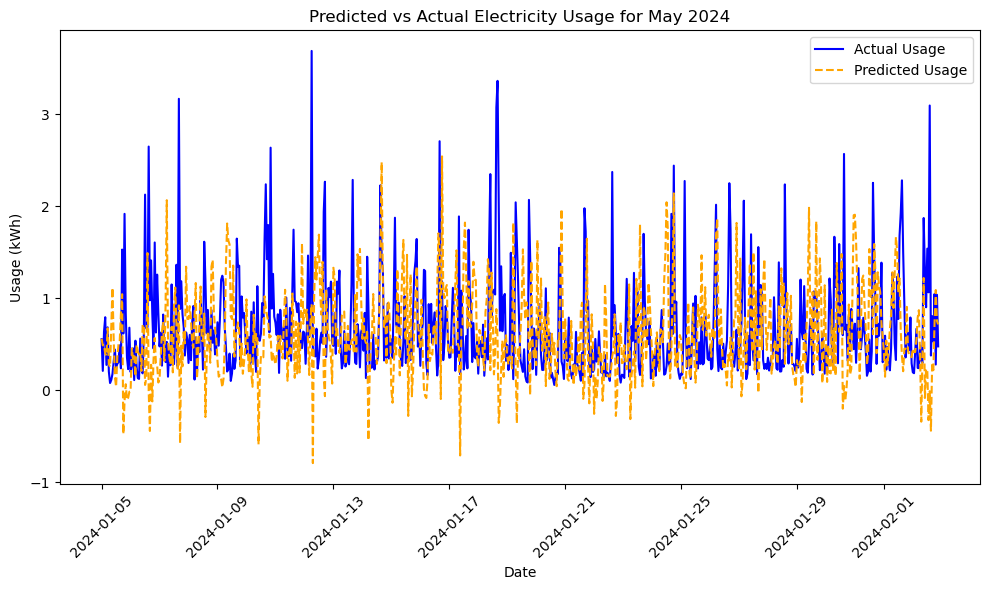

In [8]:
date_range = pd.date_range(
    start='01.05.2024', periods=len(actual_usage), freq='h')

# Plot the actual vs predicted usage
plt.figure(figsize=(10, 6))
plt.plot(date_range, actual_usage, label='Actual Usage', color='blue')
plt.plot(date_range, predictions, label='Predicted Usage',
         color='orange', linestyle='--')
plt.title('Predicted vs Actual Electricity Usage for May 2024')
plt.xlabel('Date')
plt.ylabel('Usage (kWh)')
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()